In [1]:
import torch
import sys
import os
import copy
import numpy as np
import glob
from matplotlib import pyplot as plt
from torchsummary import summary
from torch.nn import functional as F
from collections import namedtuple
import mlflow
from time import time
from sklearn import manifold, datasets

from torchvision import datasets, transforms, utils
from skimage.draw import random_shapes

from tqdm.notebook import tqdm
import argparse
from omegaconf import OmegaConf
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
from monai.data import Dataset
import h5py
sys.path.insert(0,'/media/htic/_srv_Data/Ayantika_codebase/')
import utils.gauss_kernel as gauss_kernel_
import models.pathology_track_models as ssae
import trainer as trainer_class
import datasets.slice_data_loader_h5 as sdl_h5
import utils.gauss_kernel as gauss_kernel_
from models.glow_model import Glow
import models.BAUR_VAE as VAE_baseline
import evaluation as eval_
import models.ssae_KL_top_level as ssae_KL
import utils.slice_view as slice_view
# import models.LapSRN as Lapsrn

In [7]:
# !nvidia-smi

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'


## Dataloader with h5 files (creation & loading)

In [9]:
transforms1 = Compose(
    [
     AddChanneld(('image','label')),
     Orientationd(('image','label'),'RAS'),
#      Spacingd(('image','label'),(1,1,1)),        
     Resized(keys = ('image'),spatial_size = (128, 128,-1),mode = 'trilinear' ,align_corners = True),
     Resized(keys = ('label'),spatial_size = (128, 128,-1),mode = 'nearest' ),
     ScaleIntensityD(('image',)),
     ToTensord(('image','label')),
    ]
)


In [10]:

train_datapath_1 = '/media/htic/HD-B1/T2/IXI_colin/reg_n4_skl_strp/**.nii.gz'
train_datapath_2 = '/media/htic/HD-B1/T2/camcan_colin/reg_n4_skl_strp/**.nii.gz'
train_datapath_3 = '/media/htic/HD-B1/T2/HCP_colin/reg_n4_skl_strp/**.nii.gz'
vol_file_ext = '.nii.gz'
trainlist_1 = [{'image':x} for x in glob.glob(train_datapath_1) ][0:100]
trainlist_2 = [{'image':x} for x in glob.glob(train_datapath_2) ][0:100]
trainlist_3 = [{'image':x} for x in glob.glob(train_datapath_3) ][0:30]

datalist = trainlist_1+trainlist_2+trainlist_3

maskdir='/media/htic/_srv_Data/brain/brainmask.nii'
mask_file_ext = 'mask.nii'
masklist = [{'label':x} for x in glob.glob(maskdir)] * len(datalist)


### The loader is such that it would create h5 files if they are not created when the loader is called and executed
h5cachedir_ = '/media/htic/_srv_Data/brain/h5_data/training_T2'                                                                
h5cacheds = sdl_h5.H5CachedDataset(datalist,masklist,transforms1,h5cachedir=h5cachedir_)
torch.multiprocessing.set_sharing_strategy('file_system')
train_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 210 ,\
                                           shuffle = False ,num_workers= 4)# ,pin_memory = True)


In [11]:
val_datapath_1 = '/media/htic/HD-B1/T2/IXI_colin/reg_n4_skl_strp/**.nii.gz'
val_datapath_2 = '/media/htic/HD-B1/T2/camcan_colin/reg_n4_skl_strp/**.nii.gz'

trainlist_1 = [{'image':x} for x in glob.glob(val_datapath_1) ][150:200]
trainlist_2 = [{'image':x} for x in glob.glob(val_datapath_2) ][150:200]

datalist = trainlist_1+trainlist_2

maskdir='/media/htic/_srv_Data/brain/brainmask.nii'
masklist = [{'label':x} for x in glob.glob(maskdir)] * len(datalist)

### The loader is such that it would create h5 files if they are not created when the loader is called and executed
h5cachedir_ = '/media/htic/_srv_Data/brain/h5_data/valiadtion_T2'                                                                
h5cacheds = sdl_h5.H5CachedDataset(datalist,masklist,transforms1,h5cachedir=h5cachedir_)
torch.multiprocessing.set_sharing_strategy('file_system')
val_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 210 ,\
                                           shuffle = False ,num_workers= 4)# ,pin_memory = True)


In [12]:

brats_datapath_1 = '/media/htic/_srv_Data/brain/BRATS_HGG_T2/**_t2.nii.gz'


trainlist_1 = [{'image':x} for x in glob.glob(brats_datapath_1)]
datalist = trainlist_1


masklist = [{'label':x.split('_t2.nii.gz')[0]+'_seg.nii.gz'} for x in glob.glob(brats_datapath_1)]

### The loader is such that it would create h5 files if they are not created when the loader is called and executed
h5cachedir_ = '/media/htic/_srv_Data/brain/h5_data/BRATS_T2'                                                                
h5cacheds = sdl_h5.H5CachedDataset(datalist,masklist,transforms1,h5cachedir=h5cachedir_)
torch.multiprocessing.set_sharing_strategy('file_system')
brats_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 210 ,\
                                           shuffle = False ,num_workers= 4)# ,pin_memory = True)


## Noisy image creation

In [8]:
# def impute_random_noise(slice_img):
#     flag = True
#     while flag:
#         result = random_shapes((128, 128), max_shapes=1, shape='rectangle',
#                                channel_axis=None, random_seed=np.random.randint(0,2000))
#         shape_img = torch.tensor(((result[0]==255)==0))
#         logic_ = torch.logical_and(slice_img>0,shape_img)
#         if logic_.sum()>400 and logic_.any()==True:
#             flag= False
#         else:
#             flag=True
#     noisy_patch = torch.rand_like(slice_img)*logic_
#     noisy_image = noisy_patch+(slice_img*(torch.logical_not(logic_)))
        
#     return noisy_image
# index_list = np.linspace(20,180,5)
# for i,batch in tqdm(enumerate(val_loader)):
#     for indx_ in index_list:
#         slice_img = batch['image'][int(indx_),0,:,:]
#         noisy_image = impute_random_noise(slice_img)
#         if indx_==20:
#             batch_img = noisy_image.unsqueeze(dim=0)
#         else:
#             batch_img = torch.cat((batch_img,noisy_image.unsqueeze(dim=0)),dim=0)
#     batch_imgs = batch_img.unsqueeze(dim=1)
#     torch.save(batch_imgs,'/media/htic/_srv_Data/brain/pt_pertubed_validation_data/'+str(i).zfill(4)+'_batch_img.pt')
    

In [2]:
for i in range(0,100):
    batch_img = torch.load('/media/htic/_srv_Data/brain/pt_pertubed_validation_data/00'+str(i).zfill(2)+'_batch_img.pt')
    

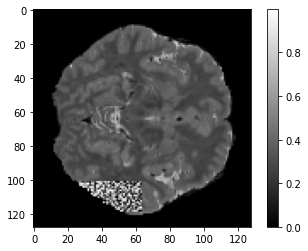

In [9]:
plt.imshow(batch_img[1,0,:,:],cmap='gray')
plt.colorbar()

# torch.logical_and(shape_img,batch['label'][0,0,:,:])
# random_shapes?

### Arguments for GLOW

In [7]:
parser = argparse.ArgumentParser(description="Glow trainer")
parser.add_argument("--batch", default=5, type=int, help="batch size")
parser.add_argument("--epoch", default=10, type=int, help="maximum iterations")
parser.add_argument(
    "--n_flow", default=32, type=int, help="number of flows in each block"
)
parser.add_argument("--n_block", default=4, type=int, help="number of blocks")
parser.add_argument(
    "--no_lu",
    action="store_true",
    help="use plain convolution instead of LU decomposed version",
)
parser.add_argument(
    "--affine", action="store_true", help="use affine coupling instead of additive"
)
parser.add_argument("--n_bits", default=5, type=int, help="number of bits")
parser.add_argument("--lr", default=1e-4, type=float, help="learning rate")
parser.add_argument("--img_size", default=128, type=int, help="image size")
parser.add_argument("--temp", default=0.7, type=float, help="temperature of sampling")
parser.add_argument("--n_sample", default=20, type=int, help="number of samples")
args = parser.parse_args('')
args_dict = vars(args)

conf_ = OmegaConf.create(args_dict)
OmegaConf.save(config=conf_, f='./glow_args.yaml')
OmegaConf.to_yaml(conf_)
args= OmegaConf.load('./glow_args.yaml')



In [8]:
def calc_z_shapes(n_channel, input_size, n_flow, n_block):
    z_shapes = []

    for i in range(n_block - 1):
        input_size //= 2
        n_channel *= 2

        z_shapes.append((n_channel, input_size, input_size))

    input_size //= 2
    z_shapes.append((n_channel * 4, input_size, input_size))

    return z_shapes


def calc_loss(log_p, logdet, image_size, n_bins):
    # log_p = calc_log_p([z_list])
#     n_pixel = image_size * image_size * 3
    n_pixel = image_size * image_size * 1

    loss = -log(n_bins) * n_pixel
    loss = loss + logdet + log_p

    return (
        (-loss / (log(2) * n_pixel)).mean(),
        (log_p / (log(2) * n_pixel)).mean(),
        (logdet / (log(2) * n_pixel)).mean(),
    )


## Models

In [11]:
################### GLOW ###############################

model_single = Glow(
        1, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu
    )
    
model = torch.nn.DataParallel(model_single)
# model = model_single


weights_path = '/media/htic/_srv_Data/Research/MICCAI_Disentanglement/best_weights/model_000009.pth'
model.load_state_dict(torch.load(weights_path))
model = model.to(device)


In [13]:
VAE = VAE_baseline.Baur_VAE()
# summary(VAE.to(device),(1,128,128))
weights_path = '/srv/project/APW/Research/MICCAI_Disentanglement/mlruns/5/cfe0c37f82af452791f1ccf6ecf1a505/checkpoints/epoch_130.ckpt'
VAE.load_state_dict(torch.load(weights_path))
VAE = VAE.to(device)

In [45]:

disc_ = discriminator_.Discriminator(latent_dim=128)
# summary(disc_.to(device),(1,1,128))
VAE = VAE_baseline.Baur_VAE()
# summary(VAE.to(device),(1,128,128))
weight_ = '/media/htic/_srv_Data/Research/MICCAI_Disentanglement/best_weights/FactorVAE/checkpoints/epoch_25.ckpt'
VAE.load_state_dict(torch.load(weight_))
FactorVAE = VAE.to(device)

In [16]:
# ######### SSAE model #############
gauss_kernel = gauss_kernel_.get_gaussian_kernel()
AE0 = copy.deepcopy(ssae.custom_AE1(1,1))
AE1 = copy.deepcopy(ssae.custom_AE1(1,1))
AE2 = copy.deepcopy(ssae.custom_AE1(1,1))
# device = 'cuda:0'
model_ssae = ssae.model(AE0,AE1,AE2,gauss_kernel)
model_ssae = model_ssae.to(device)
# summary(model_ssae,(1,128,128))
model_ssae = model_ssae.to(device)
# print(model_ssae)
# summary(model_ssae,(1,128,128))
weights_path = '/media/htic/_srv_Data/Research/MICCAI_Disentanglement/mlruns/1/945bab50c6974a40b2e2e1abfc1a8ce2/checkpoints/best_epoch_57.ckpt'
model_ssae.load_state_dict(torch.load(weights_path))
model_ssae = model_ssae.to(device)

In [21]:
index_list = np.linspace(20,180,10)            
with torch.no_grad():
    for i,batch in enumerate(tqdm(brats_loader)):
        image,label = batch['image'].to(device),batch['label'].to(device)
        s = label.view(label.shape[0], -1).sum(dim = -1)
        index_ = torch.nonzero(s==s.max())[0][0]
        if index_+3>209:
            index_=index_-3
        elif index_-2<0:
            index_=index_+2
        else:
            index_=index_
        image = image[index_-2:index_+3,:,:,:]
        label = label[index_-2:index_+3,:,:,:]
        image = image*label
        
        model_output_ = model_ssae(image)
        latent_space_1 = model_output_[-1]
        if i==0:
            latent_sapce_ssae_pathology = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_ssae_pathology = torch.cat((latent_sapce_ssae_pathology,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)
        break

  0%|          | 0/132 [00:00<?, ?it/s]

In [25]:
# plt.imshow(model_output_[0][1,0,:,:].detach().cpu(),cmap='gray')
# model_output_[-1].view(-1,5,16*64)

In [54]:
index_list = np.linspace(20,180,5)

with torch.no_grad():
    for i,image in enumerate(tqdm(val_loader)):   
        image = image['image'][index_list].to(device)
        model_output_ = model_ssae(image)
        latent_space_1 = model_output_[-1]
        if i==0:
            latent_sapce_ssae_normal = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_ssae_normal = torch.cat((latent_sapce_ssae_normal,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)
            
with torch.no_grad():
    for i,image in enumerate(tqdm(brats_loader)):   
        image = image['image'][index_list].to(device)
        model_output_ = model_ssae(image)
        latent_space_1 = model_output_[-1]
        if i==0:
            latent_sapce_ssae_brats = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_ssae_brats = torch.cat((latent_sapce_ssae_brats,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)
            
with torch.no_grad():
    for i,batch in enumerate(tqdm(brats_loader)):
        image,label = batch['image'].to(device),batch['label'].to(device)
        s = label.view(label.shape[0], -1).sum(dim = -1)
        index_ = torch.nonzero(s==s.max())[0][0]
        if index_+3>209:
            index_=index_-3
        elif index_-2<0:
            index_=index_+2
        else:
            index_=index_
        image = image[index_-2:index_+3,:,:,:]
        label = label[index_-2:index_+3,:,:,:]
        image = image*label
        
        model_output_ = model_ssae(image)
        latent_space_1 = model_output_[-1]
        if i==0:
            latent_sapce_ssae_pathology = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_ssae_pathology = torch.cat((latent_sapce_ssae_pathology,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)
with torch.no_grad():
    for i in tqdm(range(0,100)):
        image = torch.load('/media/htic/_srv_Data/brain/pt_pertubed_validation_data/00'+str(i).zfill(2)+'_batch_img.pt')
        model_output_ = model_ssae(image.to(device))
        latent_space_1 = model_output_[-1]
        if i==0:
            latent_sapce_ssae_noisy = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_ssae_noisy = torch.cat((latent_sapce_ssae_noisy,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
def normalize_(z_sample):
    z_sample_=[]
    z_sample_.append(z_sample[0]*(3/torch.abs(z_sample[0].max())))
    z_sample_.append(z_sample[1]*(3/torch.abs(z_sample[1].max())))
    z_sample_.append(z_sample[2]*(3/torch.abs(z_sample[2].max())))
    z_sample_.append(z_sample[3]*(3/torch.abs(z_sample[3].max())))
    return z_sample_

In [269]:
index_list = np.linspace(20,180,10)
n_bins = 2.0 ** args.n_bits
with torch.no_grad():
    for i,image in enumerate(tqdm(val_loader)):   
        image = image['image'][index_list].to(device)
        image = image * 255

        if args.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - args.n_bits))

        image = image / n_bins - 0.5

    
        log_p, logdet, latent_space_unnorm = model(image + torch.rand_like(image) / n_bins)
        
        
        
        
        latent_space_1 = normalize_(latent_space_unnorm)
            
        if i==0:
            latent_sapce_0_glow_normal_10 = latent_space_1[0].view(-1,2*64*64).unsqueeze(dim=0)
            latent_sapce_1_glow_normal_10 = latent_space_1[1].view(-1,4*32*32).unsqueeze(dim=0)
            latent_sapce_2_glow_normal_10 = latent_space_1[2].view(-1,8*16*16).unsqueeze(dim=0)
            latent_sapce_3_glow_normal_10 = latent_space_1[3].view(-1,32*8*8).unsqueeze(dim=0)
        else:
            latent_sapce_0_glow_normal_10 = torch.cat((latent_sapce_0_glow_normal_10,\
                                                  latent_space_1[0].view(-1,2*64*64).unsqueeze(dim=0)),dim=0)
            latent_sapce_1_glow_normal_10 = torch.cat((latent_sapce_1_glow_normal_10,\
                                                  latent_space_1[1].view(-1,4*32*32).unsqueeze(dim=0)),dim=0)
            latent_sapce_2_glow_normal_10 = torch.cat((latent_sapce_2_glow_normal_10,\
                                                  latent_space_1[2].view(-1,8*16*16).unsqueeze(dim=0)),dim=0)
            latent_sapce_3_glow_normal_10 = torch.cat((latent_sapce_3_glow_normal_10,\
                                                  latent_space_1[3].view(-1,32*8*8).unsqueeze(dim=0)),dim=0)
        



  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:


index_list = np.linspace(20,180,5)
n_bins = 2.0 ** args.n_bits
with torch.no_grad():
    for i in tqdm(range(0,100)):
        image = torch.load('/media/htic/_srv_Data/brain/pt_pertubed_validation_data/00'+str(i).zfill(2)+'_batch_img.pt')
    
#     for i,image in enumerate(tqdm(val_loader)):   
#         image = image['image'][index_list].to(device)
        image = image * 255

        if args.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - args.n_bits))

        image = image / n_bins - 0.5

    
        log_p, logdet, latent_space_unnorm = model(image + torch.rand_like(image) / n_bins)      
        
        
        
        latent_space_1 = normalize_(latent_space_unnorm)
        if i==0:
            latent_sapce_0_glow_noisy = latent_space_1[0].view(-1,2*64*64).unsqueeze(dim=0)
            latent_sapce_1_glow_noisy = latent_space_1[1].view(-1,4*32*32).unsqueeze(dim=0)
            latent_sapce_2_glow_noisy = latent_space_1[2].view(-1,8*16*16).unsqueeze(dim=0)
            latent_sapce_3_glow_noisy = latent_space_1[3].view(-1,32*8*8).unsqueeze(dim=0)
        else:
            latent_sapce_0_glow_noisy = torch.cat((latent_sapce_0_glow_noisy,\
                                                  latent_space_1[0].view(-1,2*64*64).unsqueeze(dim=0)),dim=0)
            latent_sapce_1_glow_noisy = torch.cat((latent_sapce_1_glow_noisy,\
                                                  latent_space_1[1].view(-1,4*32*32).unsqueeze(dim=0)),dim=0)
            latent_sapce_2_glow_noisy = torch.cat((latent_sapce_2_glow_noisy,\
                                                  latent_space_1[2].view(-1,8*16*16).unsqueeze(dim=0)),dim=0)
            latent_sapce_3_glow_noisy = torch.cat((latent_sapce_3_glow_noisy,\
                                                  latent_space_1[3].view(-1,32*8*8).unsqueeze(dim=0)),dim=0)
        



  0%|          | 0/100 [00:00<?, ?it/s]

In [41]:


index_list = np.linspace(20,180,5)
n_bins = 2.0 ** args.n_bits
with torch.no_grad():
    
    for i,batch in enumerate(tqdm(brats_loader)):   
        image,label = batch['image'],batch['label']
        s = label.view(label.shape[0], -1).sum(dim = -1)
        index_ = torch.nonzero(s==s.max())[0][0]
        if index_+3>209:
            index_=index_-3
        elif index_-2<0:
            index_=index_+2
        else:
            index_=index_
        image = image[index_-2:index_+3,:,:,:]
        label = label[index_-2:index_+3,:,:,:]
        
        image = image * 255

        if args.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - args.n_bits))

        image = image / n_bins - 0.5

    
        log_p, logdet, latent_space_unnorm = model(image + torch.rand_like(image) / n_bins)      
        
        
        
        latent_space_1 = normalize_(latent_space_unnorm)
        if i==0:
            latent_sapce_0_glow_brats = latent_space_1[0].view(-1,2*64*64).unsqueeze(dim=0)
            latent_sapce_1_glow_brats = latent_space_1[1].view(-1,4*32*32).unsqueeze(dim=0)
            latent_sapce_2_glow_brats = latent_space_1[2].view(-1,8*16*16).unsqueeze(dim=0)
            latent_sapce_3_glow_brats = latent_space_1[3].view(-1,32*8*8).unsqueeze(dim=0)
        else:
            latent_sapce_0_glow_brats = torch.cat((latent_sapce_0_glow_brats,\
                                                  latent_space_1[0].view(-1,2*64*64).unsqueeze(dim=0)),dim=0)
            latent_sapce_1_glow_brats = torch.cat((latent_sapce_1_glow_brats,\
                                                  latent_space_1[1].view(-1,4*32*32).unsqueeze(dim=0)),dim=0)
            latent_sapce_2_glow_brats = torch.cat((latent_sapce_2_glow_brats,\
                                                  latent_space_1[2].view(-1,8*16*16).unsqueeze(dim=0)),dim=0)
            latent_sapce_3_glow_brats = torch.cat((latent_sapce_3_glow_brats,\
                                                  latent_space_1[3].view(-1,32*8*8).unsqueeze(dim=0)),dim=0)
        



  0%|          | 0/132 [00:00<?, ?it/s]

In [47]:


index_list = np.linspace(20,180,5)
n_bins = 2.0 ** args.n_bits
with torch.no_grad():
    
    for i,batch in enumerate(tqdm(brats_loader)):   
        image,label = batch['image'],batch['label']
        s = label.view(label.shape[0], -1).sum(dim = -1)
        index_ = torch.nonzero(s==s.max())[0][0]
        if index_+3>209:
            index_=index_-3
        elif index_-2<0:
            index_=index_+2
        else:
            index_=index_
        image = image[index_-2:index_+3,:,:,:]
        label = label[index_-2:index_+3,:,:,:]
        image = image*label
        image = image * 255

        if args.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - args.n_bits))

        image = image / n_bins - 0.5

    
        log_p, logdet, latent_space_unnorm = model(image + torch.rand_like(image) / n_bins)      
        
        
        
        latent_space_1 = normalize_(latent_space_unnorm)
        if i==0:
            latent_sapce_0_glow_pathology = latent_space_1[0].view(-1,2*64*64).unsqueeze(dim=0)
            latent_sapce_1_glow_pathology = latent_space_1[1].view(-1,4*32*32).unsqueeze(dim=0)
            latent_sapce_2_glow_pathology = latent_space_1[2].view(-1,8*16*16).unsqueeze(dim=0)
            latent_sapce_3_glow_pathology = latent_space_1[3].view(-1,32*8*8).unsqueeze(dim=0)
        else:
            latent_sapce_0_glow_pathology = torch.cat((latent_sapce_0_glow_pathology,\
                                                  latent_space_1[0].view(-1,2*64*64).unsqueeze(dim=0)),dim=0)
            latent_sapce_1_glow_pathology = torch.cat((latent_sapce_1_glow_pathology,\
                                                  latent_space_1[1].view(-1,4*32*32).unsqueeze(dim=0)),dim=0)
            latent_sapce_2_glow_pathology = torch.cat((latent_sapce_2_glow_pathology,\
                                                  latent_space_1[2].view(-1,8*16*16).unsqueeze(dim=0)),dim=0)
            latent_sapce_3_glow_pathology = torch.cat((latent_sapce_3_glow_pathology,\
                                                  latent_space_1[3].view(-1,32*8*8).unsqueeze(dim=0)),dim=0)
        
        


  0%|          | 0/132 [00:00<?, ?it/s]

In [47]:
index_list = np.linspace(20,180,10)
with torch.no_grad():
    for i,image in enumerate(tqdm(val_loader)):   
        image = image['image'][index_list].to(device)
        model_output_ = FactorVAE(image)
        latent_space_1 = model_output_[1]
        if i==0:
            latent_sapce_FactorVAE_normal_10 = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_FactorVAE_normal_10 = torch.cat((latent_sapce_FactorVAE_normal_10,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)
            

  0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
index_list = np.linspace(20,180,5)

with torch.no_grad():
    for i,image in enumerate(tqdm(val_loader)):   
        image = image['image'][index_list].to(device)
        model_output_ = FactorVAE(image)
        latent_space_1 = model_output_[1]
        if i==0:
            latent_sapce_FactorVAE_normal = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_FactorVAE_normal = torch.cat((latent_sapce_FactorVAE_normal,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)
            
with torch.no_grad():
    for i,image in enumerate(tqdm(brats_loader)):   
        image = image['image'][index_list].to(device)
        model_output_ = FactorVAE(image)
        latent_space_1 = model_output_[1]
        if i==0:
            latent_sapce_FactorVAE_brats = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_FactorVAE_brats = torch.cat((latent_sapce_FactorVAE_brats,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)
            
with torch.no_grad():
    for i,batch in enumerate(tqdm(brats_loader)):
        image,label = batch['image'].to(device),batch['label'].to(device)
        s = label.view(label.shape[0], -1).sum(dim = -1)
        index_ = torch.nonzero(s==s.max())[0][0]
        if index_+3>209:
            index_=index_-3
        elif index_-2<0:
            index_=index_+2
        else:
            index_=index_
        image = image[index_-2:index_+3,:,:,:]
        label = label[index_-2:index_+3,:,:,:]
        image = image*label
        
        model_output_ = FactorVAE(image)
        latent_space_1 = model_output_[1]
        if i==0:
            latent_sapce_FactorVAE_pathology = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_FactorVAE_pathology = torch.cat((latent_sapce_FactorVAE_pathology,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)
with torch.no_grad():
    for i in tqdm(range(0,100)):
        image = torch.load('/media/htic/_srv_Data/brain/pt_pertubed_validation_data/00'+str(i).zfill(2)+'_batch_img.pt')
        model_output_ = FactorVAE(image.to(device))
        latent_space_1 = model_output_[1]
        if i==0:
            latent_sapce_FactorVAE_noisy = latent_space_1.unsqueeze(dim=0)
            
        else:
            latent_sapce_FactorVAE_noisy = torch.cat((latent_sapce_FactorVAE_noisy,\
                                                  latent_space_1.unsqueeze(dim=0)),dim=0)

  0%|          | 0/132 [00:00<?, ?it/s]

In [14]:

latent_sapce_0_glow_pathology = torch.load('./latent_space/glow/latent_sapce_0_glow_pathology.pt')
latent_sapce_0_glow_noisy = torch.load( './latent_space/glow/latent_sapce_0_glow_noisy.pt')

latent_sapce_0_glow_normal = torch.load( './latent_space/glow/latent_sapce_0_glow_normal.pt')
latent_sapce_0_glow_normal_10 = torch.load( './latent_space/glow/latent_sapce_0_glow_normal_10.pt')
latent_sapce_0_glow_brats = torch.load('./latent_space/glow/latent_sapce_0_glow_brats.pt')

# latent_sapce_1_glow_pathology = torch.save('./latent_space/glow/latent_sapce_1_glow_pathology.pt')


# torch.save(, './latent_space/glow/latent_sapce_2_glow_pathology.pt')


# torch.save(latent_sapce_3_glow_pathology, './latent_space/glow/latent_sapce_3_glow_pathology.pt')

In [31]:
# './latent_space/VAE/'
# latent_sapce_VAE_pathology = torch.load('./latent_space/glow/latent_sapce_0_glow_pathology.pt')
# latent_sapce_VAE_noisy = torch.load( './latent_space/glow/latent_sapce_0_glow_noisy.pt')

# latent_sapce_VAE_normal = torch.load( './latent_space/glow/latent_sapce_0_glow_normal.pt')
# latent_sapce_VAE_normal_10 = torch.load( './latent_space/glow/latent_sapce_0_glow_normal_10.pt')
# latent_sapce_VAE_brats = torch.load('./latent_space/glow/latent_sapce_0_glow_brats.pt')

In [52]:
# './latent_space/VAE/'
torch.save(latent_sapce_FactorVAE_pathology,'./latent_space/FactorVAE/latent_sapce_FactorVAE_pathology.pt')
torch.save( latent_sapce_FactorVAE_noisy,'./latent_space/FactorVAE/latent_sapce_FactorVAE_noisy.pt')

torch.save( latent_sapce_FactorVAE_normal,'./latent_space/FactorVAE/latent_sapce_FactorVAE_normal.pt')
torch.save(latent_sapce_FactorVAE_normal_10, './latent_space/FactorVAE/latent_sapce_FactorVAE_normal_10.pt')
torch.save(latent_sapce_FactorVAE_brats,'./latent_space/FactorVAE/latent_sapce_FactorVAE_brats.pt')

In [56]:
torch.save(latent_sapce_ssae_pathology,'./latent_space/ssae/latent_sapce_ssae_pathology.pt')
torch.save( latent_sapce_ssae_noisy,'./latent_space/ssae/latent_sapce_ssae_noisy.pt')

torch.save( latent_sapce_ssae_normal,'./latent_space/ssae/latent_sapce_ssae_normal.pt')
torch.save(latent_sapce_ssae_normal_10, './latent_space/ssae/latent_sapce_ssae_normal_10.pt')
torch.save(latent_sapce_ssae_brats,'./latent_space/ssae/latent_sapce_ssae_brats.pt')

In [12]:
patho = latent_sapce_0_glow_pathology.to('cpu').view(-1,latent_sapce_0_glow_pathology.shape[-1])
normal = latent_sapce_0_glow_normal_10.to('cpu').view(-1,latent_sapce_0_glow_normal_10.shape[-1])

noisy = latent_sapce_0_glow_noisy.to('cpu').view(-1,latent_sapce_0_glow_noisy.shape[-1])

brats = latent_sapce_0_glow_brats.to('cpu').view(-1,latent_sapce_0_glow_brats.shape[-1])



In [96]:
len(patho)

660

## Clustering

In [ ]:
# normal_label = np.zeros_like(normal.numpy())[:,0]
# brats_label = np.ones_like(brats.numpy())[:,0]

# noisy_label = (np.ones_like(noisy.numpy())*2)[:,0]
# patho_label = (np.ones_like(patho.numpy())*3)[:,0]
# X = torch.cat((normal,brats,noisy,patho),dim=0).numpy()
# y = np.concatenate((normal_label,brats_label,noisy_label,patho_label),axis=0)
# y = y.astype('int64')

In [20]:
noisy_label = np.zeros_like(noisy.numpy())[:,0]
brats_label = np.ones_like(brats.numpy())[:,0]



patho_label = (np.ones_like(patho.numpy())*2)[:,0]
normal_label = (np.ones_like(normal.numpy())*3)[:,0]
X = torch.cat((noisy,brats,patho,normal),dim=0).numpy()
y = np.concatenate((noisy_label,brats_label,patho_label,normal_label),axis=0)
y = y.astype('int64')

In [21]:
n_samples, n_features = X.shape
np.random.seed(0)

In [425]:
# Visualize the clustering
def plot_clustering(X_red ,labels,title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for digit,name in zip(np.array(range(0,4)),['brats','noisy','only Pathology','Normal']):
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
#             c=plt.cm.nipy_spectral(labels[y == digit] / 4),
            alpha=0.7,
            label=f"${name}$"
        )
        plt.legend()

    plt.xlabel('First embedded dimension')
    plt.ylabel('Second embedded dimension')
    if title is not None:
        plt.title(title, size=12)
#     plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.legend()
#     plt.savefig('./images_save/Spectral_embeddings_0_1_2_3.eps')
# plot_clustering(X_red, "Spectral Embeddings from GLOW")

In [426]:
# # Visualize the clustering
# def plot_clustering(X_red ,labels,title=None):
#     x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
#     X_red = (X_red - x_min) / (x_max - x_min)

#     plt.figure(figsize=(6, 4))
#     for digit,name in zip(np.array(range(0,3)),['Noisy','brats','Normal']):
#         plt.scatter(
#             *X_red[y == digit].T,
#             marker=f"${digit}$",
#             s=50,
# #             c=plt.cm.nipy_spectral(labels[y == digit] / 3),
#             alpha=0.5,
#             label=f"${name}$"
#         )
#         plt.legend()

#     plt.xlabel('First embedded dimension')
#     plt.ylabel('Second embedded dimension')
#     if title is not None:
#         plt.title(title, size=12)
# #     plt.axis("off")
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.legend()
#     plt.savefig('./images_save/Spectral_embeddings_0_1_2.eps')
# # plot_clustering(X_red, "Spectral Embeddings from GLOW")

Computing embedding
Done.
ward :	0.03s


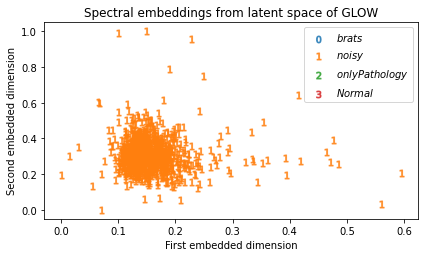

In [427]:
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=4)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "Spectral embeddings from latent space of GLOW")
    break

Computing embedding
Done.
ward :	0.07s


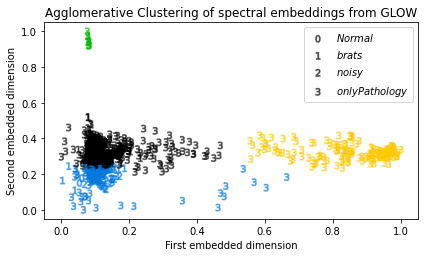

In [197]:
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=4)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "Agglomerative Clustering of spectral embeddings from GLOW")
    break

## Outlier score

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

In [123]:
noisy_label = (np.ones_like(noisy.numpy())*-1)[:,0]
brats_label = (np.ones_like(brats.numpy())*-1)[:,0]
patho_label = (np.ones_like(patho.numpy())*-1)[:,0]
normal_label = (np.ones_like(normal.numpy())*1)[:,0]
X_all = torch.cat((noisy,brats,patho,normal),dim=0).numpy()

y_all = np.concatenate((noisy_label,brats_label,patho_label,normal_label),axis=0)
y_all = y_all.astype('int64')
X = torch.cat((noisy[0:60],brats[0:60],patho[0:60],normal),dim=0).numpy()
y = np.concatenate((noisy_label[0:60],brats_label[0:60],patho_label[0:60],normal_label),axis=0)
y = y.astype('int64')

In [226]:

X_spectral_all = X_all
# manifold.SpectralEmbedding(n_components=2).fit_transform(X_all)
X_spectral = X
# manifold.SpectralEmbedding(n_components=2).fit_transform(X)
clf = LocalOutlierFactor(n_neighbors=100, contamination=0.1)
y_pred = clf.fit_predict(X_spectral)
n_errors = (y_pred != y).sum()
X_scores = clf.negative_outlier_factor_

In [199]:
np.unique(y_pred[0:182] != y[0:182],return_counts=True)
# np.where((y_pred[0:182] != y[0:182])==True)

(array([False,  True]), array([ 63, 119]))

In [227]:
clf.novelty=True
X_scores_outliers = clf.score_samples(X_spectral_all[0:1000,:])

X_scores = clf.score_samples(X_spectral)
radius = X_scores
# ((X_scores.max() - X_scores) / (X_scores.max() - X_scores.min()))
radius_outlier = X_scores_outliers
# (X_scores_outliers.max()-X_scores_outliers)/(X_scores_outliers.max()-X_scores_outliers.min())

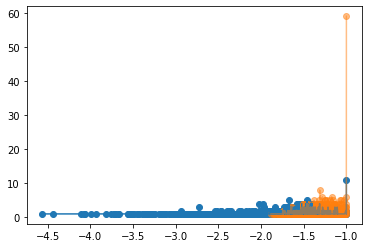

In [228]:

# radius = X_scores
outlier_score = radius_outlier.round(3)
plt.scatter(np.unique(outlier_score,return_counts=True)[0],np.unique(outlier_score,return_counts=True)[1])
inlier_score = radius[182:len(X)].round(3)
plt.scatter(np.unique(inlier_score,return_counts=True)[0],np.unique(inlier_score,return_counts=True)[1],alpha=0.5)

plt.plot(np.unique(outlier_score,return_counts=True)[0],np.unique(outlier_score,return_counts=True)[1])
# inlier_score = radius[182:len(X)].round(5)
plt.plot(np.unique(inlier_score,return_counts=True)[0],np.unique(inlier_score,return_counts=True)[1],alpha=0.5)

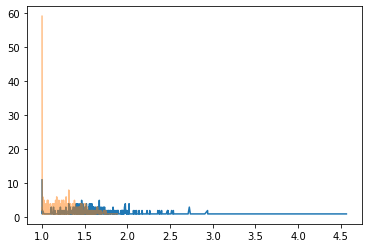

In [233]:
x1,y1 = np.unique(np.abs(outlier_score),return_counts=True)
x2,y2 = np.unique(np.abs(inlier_score),return_counts=True)

plt.plot(x1,y1)
plt.plot(x2,y2,alpha=0.5)


prediction errors: 17.51% samples are misclassifed


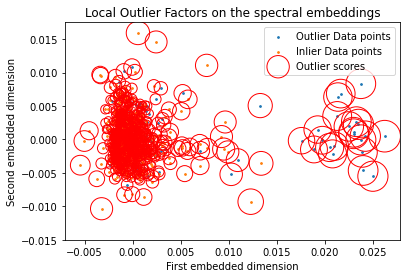

In [423]:
plt.title("Local Outlier Factors on the spectral embeddings")

plt.scatter(X_spectral[0:182, 0], X_spectral[0:182, 1], s=3.0, label="Outlier Data points")
plt.scatter(X_spectral[182:len(X), 0], X_spectral[182:len(X), 1], s=3.0, label="Inlier Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X_spectral[:, 0],
    X_spectral[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)

plt.axis("tight")
# plt.xlim((-3, 3))
plt.ylim((-0.015, 0.0175))
print('prediction errors: '+str(((n_errors/len(X))*100).round(2))+'%'+' samples are misclassifed')
# legend = plt.legend(loc="upper left")
# legend.legendHandles[0]._sizes = [10]
# legend.legendHandles[1]._sizes = [20]
# plt.show()
plt.legend()
plt.xlabel('First embedded dimension')
plt.ylabel('Second embedded dimension')

plt.savefig('./images_save/Spectral_embeddings_Lof.png')

In [392]:
207/len(X)

0.1751269035532995

In [15]:

# torch.save(latent_sapce_0_glow_noisy, './latent_space/glow/latent_sapce_0_glow_noisy.pt')

# torch.save(latent_sapce_1_glow_noisy, './latent_space/glow/latent_sapce_1_glow_noisy.pt')


# torch.save(latent_sapce_2_glow_noisy, './latent_space/glow/latent_sapce_2_glow_noisy.pt')


# torch.save(latent_sapce_3_glow_noisy, './latent_space/glow/latent_sapce_3_glow_noisy.pt')

In [270]:

# torch.save( latent_sapce_0_glow_normal_10, './latent_space/glow/latent_sapce_0_glow_normal_10.pt')

# torch.save(latent_sapce_1_glow_normal_10, './latent_space/glow/latent_sapce_1_glow_normal_10.pt')


# torch.save(latent_sapce_2_glow_normal_10, './latent_space/glow/latent_sapce_2_glow_normal_10.pt')


# torch.save(latent_sapce_3_glow_normal_10, './latent_space/glow/latent_sapce_3_glow_normal_10.pt')

In [53]:

# latent_sapce_0_glow_brats = torch.load('./latent_space/glow/latent_sapce_0_glow_brats.pt')

# torch.save(latent_sapce_1_glow_brats, './latent_space/glow/latent_sapce_1_glow_brats.pt')


# torch.save(latent_sapce_2_glow_brats, './latent_space/glow/latent_sapce_2_glow_brats.pt')


# torch.save(latent_sapce_3_glow_brats, './latent_space/glow/latent_sapce_3_glow_brats.pt')